In [1]:
# allow for imports from ../src directory

from os import path as os_path, getcwd
from sys import path as sys_path

sys_path.append(os_path.dirname(getcwd())) 

In [2]:
from dataclasses import dataclass

import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy import interpolate
from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file
from src.plotting import make_simple_plot, fast_plot, plotly_line

from src.modelling import *
from src.numerics import set_num_parameters

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [3]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [4]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [5]:
unit.c

coulomb (C), [s: 1, A: 1]

In [6]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [7]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

Dictionary of model parameters

In [9]:
fluid = "kcl"

In [10]:
fluid = set_fluid_parameters("kcl")

In [11]:
fluid

Fluid(name='Potassium Chloride', symbol='KCl', component=['K', 'Cl'], valence=array([ 1., -1.]), temperature=1075.0, concentration=array([19.265, 19.265]), epsilon_r=1.0, n_component=2, n_pair=3, index=1, charge_pair=array([0]), rho=array([0]), beta=0.0, epsilon=0.0)

In [12]:
fluid.rho = np.array([1, 1, 1])

In [13]:
fluid.rho

array([1, 1, 1])

In [14]:
valence = fluid.valence
concentration = fluid.concentration
n_pair = fluid.n_pair
n_component = fluid.n_component

Numerical discretisation

In [15]:
z_cutoff = 50.0    # from UI
n_point = 2001     # from UI

In [16]:
tolerance = 1e-9
max_iteration = 100

In [17]:
discrete = set_num_parameters(n_point, z_cutoff, n_component, n_pair, tolerance, max_iteration)

In [18]:
grid_size = discrete.grid_size
z = np.linspace(0.0, z_cutoff, n_point)
z_index = np.arange(0, n_point, dtype=int)

Calculate physical constants

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [19]:
beta = 1.0 / (Boltzmann * fluid.temperature)

In [20]:
epsilon = 4.0 * np.pi * fluid.epsilon_r * epsilon_0  # units same as $\epsilon_0$ (allow for distances in angstrom)

Model potential KCl

In [21]:
read_render_markdown_file("../docs/equation_4_1.md")
read_render_markdown_file("../docs/equation_4_2.md")
read_render_markdown_file("../docs/equation_4_3.md")

$$ u_{ij}(r) = \frac{q_i q_j}{\varepsilon r} + B_{ij} \exp(-\alpha r) + \frac{C_ij}{r^6} + \frac{D_{ij}}{r^8} $$

$$ B_{ij} = \beta_{ij} \, b \exp[\alpha(\sigma_i + \sigma_j)] $$

$$ \beta_{ij} = 1 + \frac{Z_i}{n_i} + \frac{Z_j}{n_j} $$

In [22]:
n_outer_shell = np.array([8., 8.])

In [23]:
# def calc_l_index(i, j):
#     return i + j    

In [24]:
# def calc_beta_pauling(valence, n_outer_shell):
#     beta_pauling = np.zeros(n_pair)
#     for i in range(n_component):
#         for j in range(i, n_component):
#             l = calc_l_index(i, j)
#             beta_pauling[l] = 1.0 + valence[i] / n_outer_shell[i] + valence[j] / n_outer_shell[j]
#     return beta_pauling

In [25]:
beta_pauling = calc_beta_pauling(fluid.valence, n_outer_shell, n_component, n_pair)

In [26]:
beta_pauling

array([1.25, 1.  , 0.75])

In [27]:
alpha = 1.0 / 0.337
b = 0.338e-19
sigma = [1.463, 1.585]

cap_c = np.array([24.3, 48.0, 124.5]) * 1e-19
cap_d = np.array([24.0, 73.0, 250.0]) * 1e-19

In [28]:
def calc_cap_b(beta_pauling, b, alpha, sigma):
    cap_b = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            cap_b[l] = beta_pauling[l] * b * np.exp(alpha * (sigma[i] + sigma[j]))
    return cap_b

In [29]:
cap_b = calc_cap_b(beta_pauling, b, alpha, sigma)

In [30]:
cap_b

array([2.49221400e-16, 2.86350307e-16, 3.08447497e-16])

In [31]:
#TODO: Fix up choice of c(r) / c*(r) and make sure discretisation matches
# Read in some c(r) -- currently LJ charged spheres

def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj/nrcg-cr.dat.orig"
    cr_df = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr_df.set_index(0, inplace=True)
    r = cr_df.index.to_numpy()
    cr = cr_df.to_numpy()
    return cr, r

In [32]:
cr_in, r_in = load_cr()

In [33]:
cr_in.shape, r_in.shape

((4096, 3), (4096,))

In [34]:
type(r_in)

numpy.ndarray

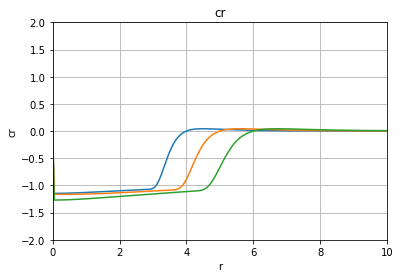

In [35]:
make_simple_plot(r_in, cr_in, "r", "cr", "cr", yliml=[-2, 2])

In [36]:

def interpolate_cr(r_in, cr_in):
    cr = np.zeros((n_point, n_pair))
    for l in range(n_pair):
        f = interpolate.interp1d(r_in, cr_in[:, l])
        r = z
        cr[:, l] = f(r)
    return cr, r

In [37]:
cr, r = interpolate_cr(r_in, cr_in)

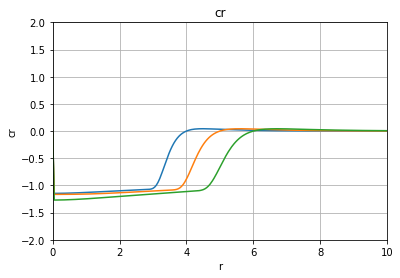

In [38]:
make_simple_plot(r, cr, "r", "cr", "cr", yliml=[-2, 2])

In [39]:
def calc_charge(valence):
    return valence * elementary_charge

In [40]:
charge = calc_charge(valence)

In [41]:
r_m = r * 1e-10  # convert distance from Angstrom to m

In [42]:
# Use same discretisation for r as z [Confirm?]

# def calc_u(valence, cap_b, alpha, cap_c, cap_d, r):
#     u = np.zeros((n_point, n_pair))
#     for i in range(n_component):
#         for j in range(i, n_component):
#             l = calc_l_index(i, j)
#             u[1:, l] = (charge[i] * charge[j]) / (r_m[1:] * epsilon) + cap_c[l] / \
#                 r[1:]**6 + cap_d[l]/r[1:]**8 + \
#                 cap_b[l] * np.exp(-alpha * r[1:])
#     return u


In [43]:
#TODO: Sort out units for this - doesn't make sense currently

u = calc_u(charge, cap_b, alpha, cap_c, cap_d, n_point, n_component, n_pair, epsilon, r)

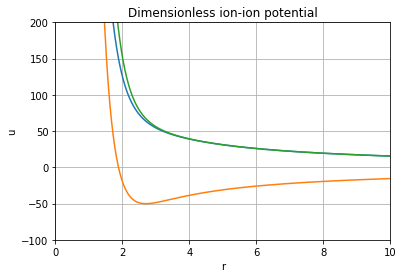

In [44]:
make_simple_plot(r, beta * u, "r", "u", "Dimensionless ion-ion potential", xliml=[0, 10], yliml=[-100, 200])

In [45]:
fig = plotly_line(r, beta*u, ["r", "u0", "u1", "u2"], xliml=[0, 10], yliml=[-100, 200])
fig.show()

In [46]:
# f.plot(x="r", y=["u0", "u1", "u2"], xlim=[0, 10], ylim=[-100, 200])

In [47]:
psi_0 = 100. / 1000.     # 100 mV (in Volts)  -- get from UI

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [48]:
def calc_rho(concentration):
    return np.array(concentration) / 1.0e27 * Avogadro

In [49]:
rho = calc_rho(concentration)

In [50]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [51]:
charge = calc_charge(valence)

In [52]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [53]:
kappa = calc_kappa(beta, rho, epsilon)

In [54]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Wall-ion soft-potential

In [55]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
# integral_0_z = np.zeros((n_point, n_component))
# integral_z_inf = np.zeros((n_point, n_component))

In [56]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [57]:
beta_phiw = beta * calc_phiw(z, n_component)

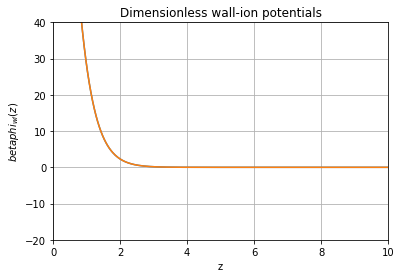

In [58]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [59]:
read_render_markdown_file("../docs/equation_3_4.md")

$$ f_{ij}^{(n)}(z) = \int_z^{\infty} dr r^n c_{ij}^{*} $$

In [60]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [61]:
# for now assume c*(r) = c(r)

c_short = cr

In [62]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [63]:
read_render_markdown_file("../docs/equation_3_5.md")

$$ c_{ij}^*(r) = c_{ij}(r) + \beta q_i q_j / (\varepsilon r) $$

In [64]:
#TODO: Too big?

beta * charge_pair[0] * elementary_charge * elementary_charge / (epsilon * 1e-10) 

2.4904672803694033e-17

In [65]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

In [66]:
# skip r = 0 to avoid divide by 0 error

#for l in range(n_pair):
#    c_short[1:, l] = c_short[1:, l]  + beta * charge_pair[l] * 1e-10 / (epsilon * r[1:])
    

In [67]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

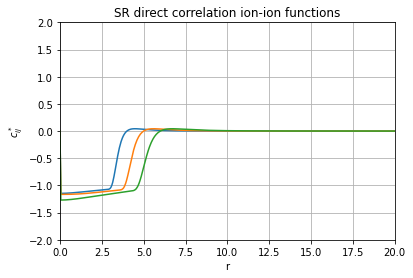

In [68]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions", xliml=[0, 20], yliml=[-2, 2])

In [69]:
def integral_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [70]:
def integral_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [71]:
f1 = integral_z_infty_dr_r_c_short(c_short, z)

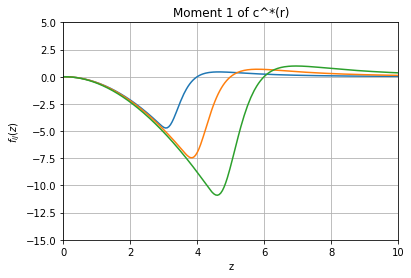

In [72]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)", yliml=[-15, 5])

In [73]:
f2 = integral_z_infty_dr_r2_c_short(c_short, z)

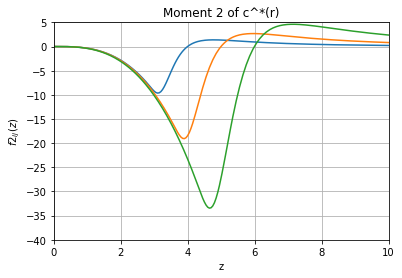

In [74]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)", yliml=[-40, 5])

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [75]:
tw_initial = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

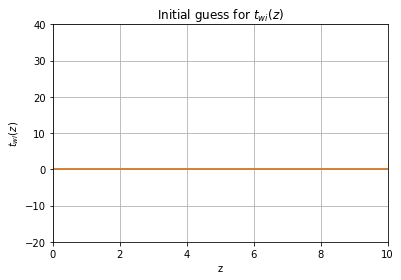

In [76]:
make_simple_plot(z, tw_initial, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [77]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i] - beta_phiw[:, i]) - 1.0
    return hw


In [78]:
hw = calc_hw(tw_initial, beta_phiw)

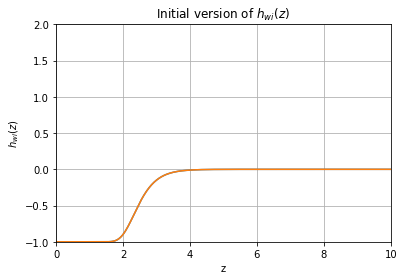

In [79]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$", yliml=[-1, 2])

In [80]:
beta_psi =  beta * psi_0

In [81]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

$$ \large t_{wi}(z) = \ln \left[ g_{wi}(z) \exp(\beta \phi_{wi}(z)) \right] $$

$$ t_{wi}(z) ~=~ - \beta q_i \psi_0 + 2 \pi \sum_{j} \bar{\rho_j} \left \{  z f_{ij}^{(1)}(z) - f_{ij}^{(2)}(z) - \left( 2 \beta q_i q_j / \varepsilon \right ) \left(  \int_0^z dt t h_{wj}(t) + z \int_{z}^{\infty} dt h_{wj}(t) \right) + \int_0^{\infty} dt h_{wj}(t) f_{ij}^{(1)} ( | z - t | ) \right \} $$

In [82]:
integral_0_z = np.zeros((n_point, n_component))
integral_z_infty = np.zeros((n_point, n_component))

In [83]:
beta_psi * charge[0]

1.0794900578186124

In [84]:
2.0 * beta * charge[0] * charge[0] / epsilon * 1e10

310.8854826014649

#### TODO: Check limits to make sure treating end points of arrays appropriately



In [85]:
beta_psi_charge = np.zeros((n_point, n_component))

In [86]:
def calc_tw_term_by_term(tw_in, beta_psi, rho, f1, f2, z):
    hw = calc_hw(tw_in, beta_phiw)

    for i in range(n_component):
        for k in range(n_point):
            integral_0_z[k, i] = trapezoid(y=hw[:k, i], x=z[:k])
            integral_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])

    for i in range(n_component):
        beta_psi_charge[:, i] = -beta_psi * charge[i]
        for k in range(n_point):
            z_minus_t = np.flip(z_index[:k])
            t_minus_z = z_index[k:] - k
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = beta_psi_charge[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l])
                # +
                #                                               (2.0 * beta * charge[i] * charge[j] / epsilon) *
                #                                               (integral_z_infty[k, j] + z[k] * integral_0_z[k, j])
                #                                               + trapezoid(y=hw[:k, j] * f1[z_minus_t, l])
                #                                               + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
    return hw, integral_0_z, integral_z_infty, beta_psi_charge, z_minus_t, t_minus_z, tw, k

In [87]:
hw_initial, integral_0_z, integral_z_infty, beta_psi_charge, z_minus_t, t_minus_z, tw, k = calc_tw_term_by_term(tw_initial, beta_psi, rho, f1, f2, z)

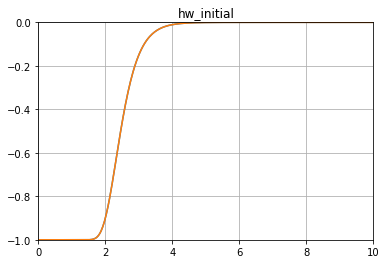

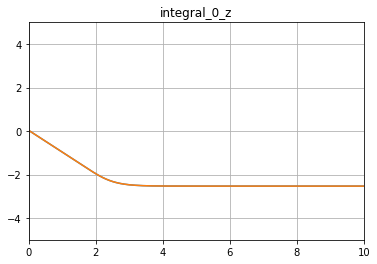

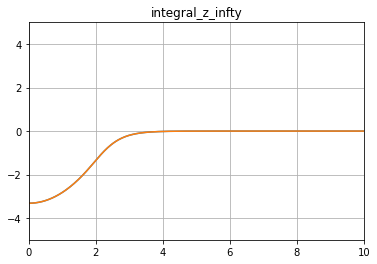

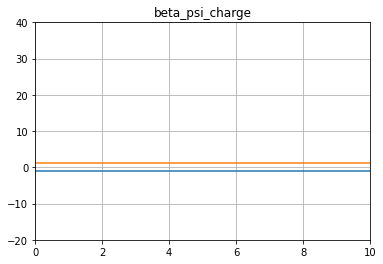

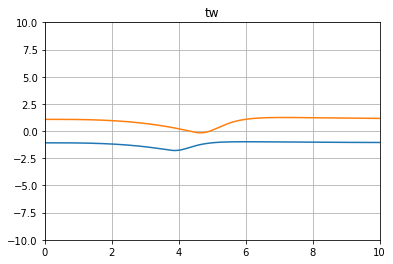

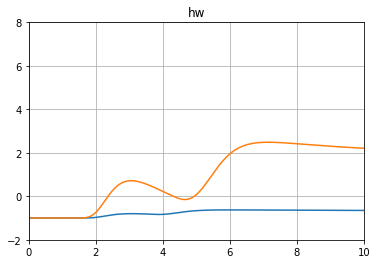

In [88]:
make_simple_plot(z, hw_initial, title="hw_initial", yliml=[-1, 0])
make_simple_plot(z, integral_0_z, title="integral_0_z", yliml=[-5, 5])
make_simple_plot(z, integral_z_infty, title="integral_z_infty", yliml=[-5, 5])
make_simple_plot(z, beta_psi_charge, title="beta_psi_charge")
make_simple_plot(z, tw, title="tw", yliml=[-10, 10])
make_simple_plot(z, calc_hw(tw, beta_phiw), title="hw", yliml=[-2, 8])

In [89]:
def calc_tw(tw_in, beta_psi, rho, f1, f2, z):
    hw = calc_hw(tw_in, beta_phiw)

    for i in range(n_component):
        for k in range(n_point):
            integral_0_z[k, i] = trapezoid(y=hw[:k, i], x=z[:k])
            integral_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])

    for i in range(n_component):
        beta_psi_charge[:, i] = -beta_psi * charge[i]
        for k in range(n_point):
            z_minus_t = np.flip(z_index[:k])
            t_minus_z = z_index[k:] - k
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = beta_psi_charge[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l] +
                                                              (2.0 * beta * charge[i] * charge[j] / epsilon / 1e10) *
                                                              (integral_z_infty[k, j] + z[k] * integral_0_z[k, j])
                                                              + trapezoid(y=hw[:k, j] * f1[z_minus_t, l])
                                                              + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
    return tw


### Numerical solver: Newton-GMRES

In [90]:
# this should equal 0 (as t(z) converges to solution)

def opt_func(tw):
    return tw - calc_tw(tw, beta_psi, rho, f1, f2, z)

In [92]:
# Documentation: https://scipy.github.io/devdocs/reference/optimize.root-krylov.html

solution = optim.root(opt_func, tw_initial, method="krylov", jac=None,
                      tol=tolerance, callback=None, options={"disp": True, "maxiter": max_iteration})


0:  |F(x)| = 55.6519; step 0.0511985
1:  |F(x)| = 52.697; step 0.0828371
2:  |F(x)| = 46.9173; step 0.167511
3:  |F(x)| = 30.5482; step 0.493538
4:  |F(x)| = 29.6365; step 1
5:  |F(x)| = 25.1308; step 1
6:  |F(x)| = 22.0025; step 0.480716
7:  |F(x)| = 22.23; step 1
8:  |F(x)| = 21.7994; step 0.499312
9:  |F(x)| = 22.777; step 1
10:  |F(x)| = 21.8745; step 1
11:  |F(x)| = 21.9568; step 1
12:  |F(x)| = 21.9067; step 0.0175735
13:  |F(x)| = 21.8426; step 0.0212153
14:  |F(x)| = 21.765; step 0.0241841
15:  |F(x)| = 21.6618; step 0.0281649
16:  |F(x)| = 21.4678; step 0.0524962
17:  |F(x)| = 21.5483; step 0.0850134
18:  |F(x)| = 21.5883; step 0.0717981
19:  |F(x)| = 21.5609; step 0.0353577
20:  |F(x)| = 21.5306; step 0.0438377
21:  |F(x)| = 21.5002; step 0.0422457
22:  |F(x)| = 21.4763; step 0.0428662
23:  |F(x)| = 21.4476; step 0.0477187
24:  |F(x)| = 21.4043; step 0.0651896
25:  |F(x)| = 21.3553; step 0.100358
26:  |F(x)| = 21.3555; step 0.165954
27:  |F(x)| = 22.5895; step 0.392264
28:  |

In [93]:
tw_solution = solution.x

In [94]:
solution.nit

300

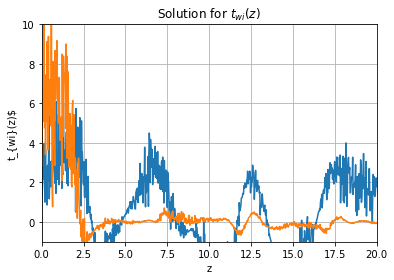

In [95]:
make_simple_plot(z, tw_solution, "z", "t_{wi}(z)$", "Solution for $t_{wi}(z)$", xliml=[0, 20], yliml=[-1, 10])

In [96]:
hw_solution = calc_hw(tw_solution, beta_phiw)

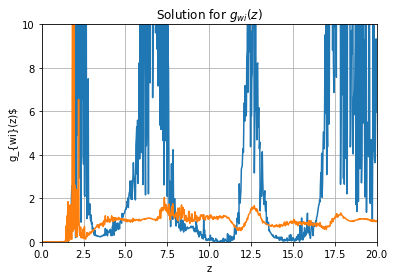

In [97]:
make_simple_plot(z, hw_solution+1, "z", "g_{wi}(z)$", "Solution for $g_{wi}(z)$", xliml=[0, 20], yliml=[0, 10])

In [98]:
assert np.sum(opt_func(tw)) < tolerance